<a href="https://colab.research.google.com/github/ribesstefano/chalmers_dat340_applied_machine_learning/blob/main/assignment_5/DAT340_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group PA 47 - Author: Stefano Ribes, ribes@chalmers.se

This Notebook can be viewed online at this link: https://colab.research.google.com/drive/1710kq0kidvPSyd3qjTWu8pZ0LLyiNgpw?usp=sharing

# Programming Assignment 5: Image Classification

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

ASSIGNMENT_ID = 'assignment_5'

data_dir = os.path.join(os.path.abspath(''), 'drive', 'MyDrive')
data_dir = os.path.join(data_dir, 'Colab Notebooks', 'dat340', ASSIGNMENT_ID)
data_dir = os.path.join(data_dir, 'data')
if os.path.exists(data_dir):
    print(f'Directory "{data_dir}" exists')
else:
    print(f'WARNING! Directory "{data_dir}" does not exist!')

Directory "/content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data" exists


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

## Introduction: Loading images from a directory

In [4]:
%%capture
import re

images_zip = re.escape(os.path.join(data_dir, 'a5_images.zip'))
images_path = '/tmp/'
!unzip $images_zip -d $images_path

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1.0 / 255)

In [6]:
imgdir = os.path.join(images_path, 'a5_images')
img_size = 64
batch_size = 128

train_generator = data_gen.flow_from_directory(os.path.join(imgdir, 'train'),
                                               target_size=(img_size, img_size),
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               classes=['other', 'car'],
                                               seed=12345,
                                               shuffle=True)
# NOTE: The `class_indices` attribute returns a dictionary of class labels and
# their associated value
num_classes = len(train_generator.class_indices.keys())

Found 1600 images belonging to 2 classes.


In [7]:
validation_generator = data_gen.flow_from_directory(
    os.path.join(imgdir, 'validation'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    classes=['other', 'car'],
    seed=12345,
    shuffle=True)

Found 576 images belonging to 2 classes.


In [8]:
Xbatch, Ybatch = train_generator.next()

In [9]:
print(f'Batch dimensions: {Xbatch.shape}')
print(f'Batch size: {Xbatch.shape[0]}')
print(f'Image dimensions: {Xbatch.shape[1:]}')
print(f'Classes: {[c for c in validation_generator.class_indices.keys()]}')
print(Ybatch.shape)

Batch dimensions: (128, 64, 64, 3)
Batch size: 128
Image dimensions: (64, 64, 3)
Classes: ['other', 'car']
(128,)


In [10]:
Ybatch[4]

1.0

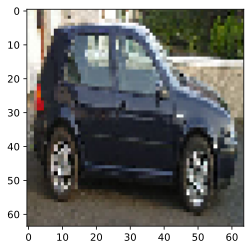

In [11]:
from matplotlib import pyplot as plt

plt.imshow(Xbatch[4])
plt.show()

In [12]:
models = {}

## Part 1: Training a convolutional neural network

* The last dense layer shouldn't have an activation function, _i.e._ be `linear`
* The stride is usually on the convolutional layer, if placed on the pooling, you might end up going outside the feature map and not doing pooling at all!

### Saving and Loading Models

In [13]:
def save_model(model, model_name):
    keras_dir = os.path.join(data_dir, model_name)
    keras_h5 = os.path.join(data_dir, model_name + '.h5')
    model.save(keras_dir)
    # model.save_weights(keras_h5) # Deprecated?
    model.save(keras_h5)
    print(f'Model saved at: {keras_h5}')

def load_model(model_name):
    keras_dir = os.path.join(data_dir, model_name)
    keras_h5 = os.path.join(data_dir, model_name + '.h5')
    print(f'keras_dir: {keras_dir}')
    print(f'keras_h5: {keras_h5}')
    if os.path.isfile(keras_h5):
        model = tf.keras.models.load_model(keras_h5)
        print(f'Model "{model_name}" loaded with weights.')
        return model
    if os.path.isdir(keras_dir):
        model = tf.keras.models.load_model(keras_dir)
        return model
    else:
        print(f'Model "{model_name}" not found in: {data_dir}')
    return None

### Defining the Model

In [14]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import Input

def make_convnet(model_name='baseline'):
    model = load_model(model_name)
    if model is not None:
        print(f'Model successfully loaded.')
    else:
        l2 = tf.keras.regularizers.l2(0.001)
        # NOTE: We are treating a binary classification problem, therefore we
        # shouldn't use a Softmax in the end.
        model = keras.Sequential(
            [
                Conv2D(32, kernel_size=5, strides=(3, 3), activation='relu', input_shape=(img_size, img_size, 3), kernel_regularizer=l2),
                MaxPooling2D(pool_size=(2, 2)),
                Conv2D(64, kernel_size=3, strides=(2, 2), activation='relu', kernel_regularizer=l2),
                MaxPooling2D(pool_size=(2, 2)),
                Flatten(),
                Dense(128, activation='linear', kernel_regularizer=l2),
                Dense(1, activation='sigmoid')
            ]
        )
        # NOTE: Again, it's a binary classification problem, we cannot use the
        # categorical_crossentropy loss function.
        model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    metrics=['accuracy'],)
    return model

### Training

In [15]:
# NOTE: The batch size is already defined in the data generator.
epochs = 15

model = make_convnet(model_name='baseline')
fit_info = model.fit(train_generator,
                     epochs=epochs,
                     verbose=1,
                     validation_data=validation_generator)
models['Baseline'] = {'model': model}

keras_dir: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/baseline
keras_h5: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/baseline.h5
Model successfully loaded.
Epoch 1/15
13/13 [==============================] - 9s 646ms/step - loss: 0.6434 - accuracy: 0.6731 - val_loss: 0.6577 - val_accuracy: 0.6198
Epoch 2/15
13/13 [==============================] - 9s 704ms/step - loss: 0.6058 - accuracy: 0.7088 - val_loss: 0.6030 - val_accuracy: 0.7170
Epoch 3/15
13/13 [==============================] - 7s 534ms/step - loss: 0.5623 - accuracy: 0.7356 - val_loss: 0.5963 - val_accuracy: 0.7222
Epoch 4/15
13/13 [==============================] - 5s 415ms/step - loss: 0.5389 - accuracy: 0.7500 - val_loss: 0.6003 - val_accuracy: 0.7222
Epoch 5/15
13/13 [==============================] - 6s 512ms/step - loss: 0.5765 - accuracy: 0.7200 - val_loss: 0.6159 - val_accuracy: 0.7083
Epoch 6/15
13/13 [==============================] - 4s 336ms/step - loss: 0.5425 - accuracy: 

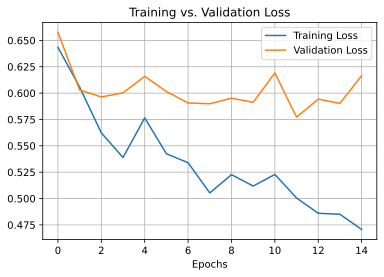

In [16]:
plt.plot(fit_info.history['loss'], label='Training Loss')
plt.plot(fit_info.history['val_loss'], label='Validation Loss')
plt.grid('both')
plt.xlabel('Epochs')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

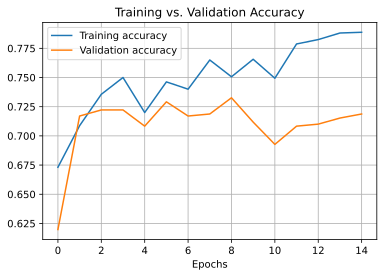

In [17]:
plt.plot(fit_info.history['accuracy'], label='Training accuracy')
plt.plot(fit_info.history['val_accuracy'], label='Validation accuracy')
plt.grid('both')
plt.xlabel('Epochs')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

In [18]:
save_model(models['Baseline']['model'], 'baseline')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/baseline/assets
Model saved at: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/baseline.h5


### Evaluation

In [19]:
loss, accuracy = models['Baseline']['model'].evaluate(validation_generator, verbose=0)
models['Baseline']['accuracy'] = accuracy
models['Baseline']['loss'] = loss
print(f'Test loss: {loss:.4f}\nTest accuracy: {accuracy:.4f}')

Test loss: 0.6165
Test accuracy: 0.7188


## Part 2: Data augmentation

### Tuning the ImageDataGenerator

In [20]:
datagen_augmented = ImageDataGenerator(rescale=1.0 / 255,
                                       horizontal_flip=True,
                                       rotation_range=10)
train_generator_augmented = datagen_augmented.flow_from_directory(
    os.path.join(imgdir, 'train'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    classes=['other', 'car'],
    seed=12345,
    shuffle=True)

Found 1600 images belonging to 2 classes.


### Training and Evaluation

In [21]:
model = make_convnet(model_name='data_augmentation')
fit_info = model.fit(train_generator_augmented,
                     epochs=epochs,
                     verbose=1,
                     validation_data=validation_generator)
models['DataAugmentation'] = {'model': model}

keras_dir: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/data_augmentation
keras_h5: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/data_augmentation.h5
Model successfully loaded.
Epoch 1/15
13/13 [==============================] - 7s 488ms/step - loss: 0.7030 - accuracy: 0.6200 - val_loss: 0.6579 - val_accuracy: 0.6701
Epoch 2/15
13/13 [==============================] - 6s 463ms/step - loss: 0.6097 - accuracy: 0.6913 - val_loss: 0.6276 - val_accuracy: 0.6910
Epoch 3/15
13/13 [==============================] - 7s 530ms/step - loss: 0.6052 - accuracy: 0.7000 - val_loss: 0.6068 - val_accuracy: 0.7083
Epoch 4/15
13/13 [==============================] - 6s 485ms/step - loss: 0.5656 - accuracy: 0.7369 - val_loss: 0.5946 - val_accuracy: 0.7031
Epoch 5/15
13/13 [==============================] - 6s 489ms/step - loss: 0.5564 - accuracy: 0.7306 - val_loss: 0.5900 - val_accuracy: 0.7170
Epoch 6/15
13/13 [==============================] - 6s 469ms/step - loss: 0

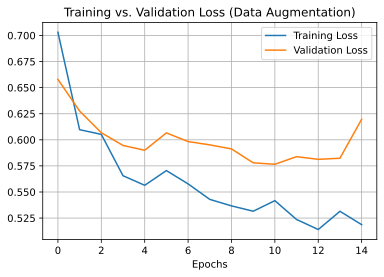

In [22]:
plt.plot(fit_info.history['loss'], label='Training Loss')
plt.plot(fit_info.history['val_loss'], label='Validation Loss')
plt.grid('both')
plt.xlabel('Epochs')
plt.title('Training vs. Validation Loss (Data Augmentation)')
plt.legend()
plt.show()

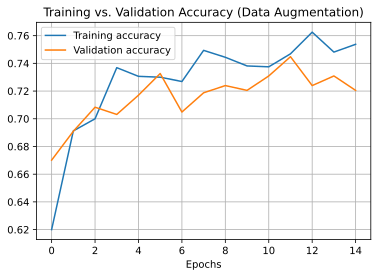

In [23]:
plt.plot(fit_info.history['accuracy'], label='Training accuracy')
plt.plot(fit_info.history['val_accuracy'], label='Validation accuracy')
plt.grid('both')
plt.xlabel('Epochs')
plt.title('Training vs. Validation Accuracy (Data Augmentation)')
plt.legend()
plt.show()

In [24]:
save_model(models['DataAugmentation']['model'], 'data_augmentation')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/data_augmentation/assets
Model saved at: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/data_augmentation.h5


In [25]:
loss, accuracy = models['DataAugmentation']['model'].evaluate(validation_generator, verbose=0)
models['DataAugmentation']['accuracy'] = accuracy
models['DataAugmentation']['loss'] = loss
print(f'Test loss: {loss:.4f}\nTest accuracy: {accuracy:.4f}')

Test loss: 0.6196
Test accuracy: 0.7205


### Baseline Comparison

Baseline accuracy: 0.719s
DataAugmentation accuracy: 0.720s


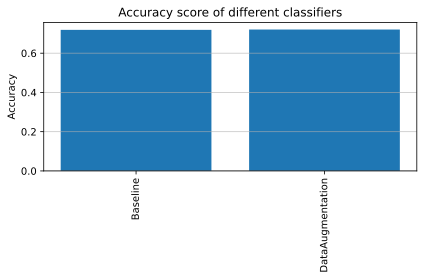

In [26]:
def plot_accuracy(model_focus=''):
    scores = []
    models_keys = []
    for model_type in models.keys():
        if model_focus in model_type:
            models_keys.append(model_type)
            print(f'{model_type} accuracy: {models[model_type]["accuracy"]:.3f}s')
            scores.append(models[model_type]['accuracy'])
    # Alphabetically sort scores according to the model types
    scores = [x for _, x in sorted(zip(models_keys, scores))]
    linspace = [x for x in range(len(models_keys))]
    plt.bar(linspace, scores)
    plt.xticks(linspace, [f'{m}' for m in sorted(models_keys)], rotation=90)
    plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
    plt.ylabel('Accuracy')
    plt.title('Accuracy score of different classifiers')
    plt.tight_layout()
    # plt.savefig(os.path.join(data_dir, f'accuracy.pdf'))
    plt.show()

plot_accuracy()

> Do you see an improvement on the validation set? (tradeoff between underfitting and overfitting)
> Again, plot the losses and accuracies. Do you see any change?

## Interlude: Applying a pre-trained convolutional neural network

In [27]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

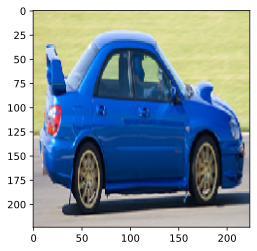

In [28]:
test_img = load_img('/tmp/a5_images/train/car/0014.jpg', target_size=(224, 224))
plt.imshow(test_img)
plt.show()

In [29]:
test_img = img_to_array(test_img)
test_img = preprocess_input(test_img).reshape(1, 224, 224, 3)

In [30]:
decode_predictions(vggmodel.predict(test_img))

49152/35363 [=========================================] - 0s 0us/step


[[('n03930630', 'pickup', 0.870323),
  ('n04037443', 'racer', 0.062589906),
  ('n02974003', 'car_wheel', 0.022384945),
  ('n04461696', 'tow_truck', 0.015090672),
  ('n04285008', 'sports_car', 0.013408987)]]

> Does the prediction make sense?

## Part 3: Using VGG-16 as a feature extractor

### Extract Features

In [31]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [32]:
import numpy as np

def create_vgg16_features(datadir='train'):
    features_dataset = os.path.join(data_dir, datadir + '_features.npy')
    if os.path.isfile(features_dataset):
        print(f'Extracted features from {datadir} dataset into {features_dataset} file.')
        return
    vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    img_generator = vgg_data_gen.flow_from_directory(
        os.path.join(imgdir, datadir),
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=False)
    cnn_features = feature_extractor.predict(img_generator)
    with open(features_dataset, 'wb') as f:
        np.save(f, cnn_features)
    print(f'Extracted features from {datadir} dataset into {features_dataset} file.')

In [33]:
create_vgg16_features('train')
create_vgg16_features('validation')

Extracted features from train dataset into /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/train_features.npy file.
Extracted features from validation dataset into /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/validation_features.npy file.


### Train the Classifier on the Extracted Features

In [34]:
def make_backend(model_name='backend'):
    model = load_model(model_name)
    if model is not None:
        print(f'Model successfully loaded.')
    else:
        l2 = tf.keras.regularizers.l2(0.001)
        # NOTE: We are treating a binary classification problem, therefore we
        # shouldn't use a Softmax in the end.
        model = keras.Sequential(
            [
                Flatten(),
                Dense(256, activation='linear', kernel_regularizer=l2),
                Dense(1, activation='sigmoid')
            ]
        )
        # NOTE: Again, it's a binary classification problem, we cannot use the
        # categorical_crossentropy loss function.
        model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    metrics=['accuracy'],)
    return model

In [35]:
def get_labels(n):
    return np.array([0] * (n // 2) + [1] * (n // 2))

def train_on_cnnfeatures(epochs=10):
    train_features = os.path.join(data_dir, 'train_features.npy')
    validation_features = os.path.join(data_dir, 'validation_features.npy')
    with open(train_features, 'rb') as f:
        x_train = np.load(f)
    with open(validation_features, 'rb') as f:
        x_test = np.load(f)
    y_train = get_labels(x_train.shape[0])
    y_test = get_labels(x_test.shape[0])
    model = make_backend()
    fit_info = model.fit(x=x_train, y=y_train,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(x_test, y_test))
    models['Backend'] = {'model': model}
    return x_test, y_test, fit_info

x_test, y_test, fit_info = train_on_cnnfeatures()

keras_dir: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/backend
keras_h5: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/backend.h5
Model successfully loaded.
Epoch 1/3
50/50 [==============================] - 1s 12ms/step - loss: 6.8799 - accuracy: 0.8875 - val_loss: 5.2504 - val_accuracy: 0.8455
Epoch 2/3
50/50 [==============================] - 0s 8ms/step - loss: 2.2008 - accuracy: 0.9312 - val_loss: 2.9359 - val_accuracy: 0.8872
Epoch 3/3
50/50 [==============================] - 0s 8ms/step - loss: 1.5811 - accuracy: 0.9544 - val_loss: 3.9308 - val_accuracy: 0.8837


In [ ]:
x_test, y_test, fit_info = train_on_cnnfeatures()

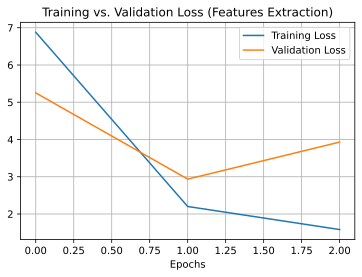

In [36]:
plt.plot(fit_info.history['loss'], label='Training Loss')
plt.plot(fit_info.history['val_loss'], label='Validation Loss')
plt.grid('both')
plt.xlabel('Epochs')
plt.title('Training vs. Validation Loss (Features Extraction)')
plt.legend()
plt.show()

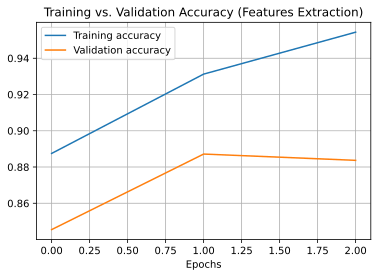

In [37]:
plt.plot(fit_info.history['accuracy'], label='Training accuracy')
plt.plot(fit_info.history['val_accuracy'], label='Validation accuracy')
plt.grid('both')
plt.xlabel('Epochs')
plt.title('Training vs. Validation Accuracy (Features Extraction)')
plt.legend()
plt.show()

In [38]:
save_model(models['Backend']['model'], 'backend')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/backend/assets
Model saved at: /content/drive/MyDrive/Colab Notebooks/dat340/assignment_5/data/backend.h5


In [39]:
loss, accuracy = models['Backend']['model'].evaluate(x=x_test, y=y_test, verbose=0)
models['Backend']['accuracy'] = accuracy
models['Backend']['loss'] = loss
print(f'Test loss: {loss:.4f}\nTest accuracy: {accuracy:.4f}')

Test loss: 3.9308
Test accuracy: 0.8837


Baseline accuracy: 0.719s
DataAugmentation accuracy: 0.720s
Backend accuracy: 0.884s


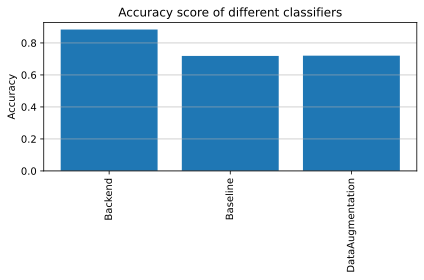

In [42]:
plot_accuracy()

## Part 4: Visualizing the learned features

In [91]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

Every kernel is a $3 \times 3 \times 3$ cube, or a three-channels image of size $3 \times 3$.

For other Convolutional layers in the network, the kernal size might be $3 \times 3 \times n$, meaning that there are $n$ channels for the kernel "image". Because of that, it might be cumbersome to visualize those layers' weights.

In [86]:
def kernel_image(weights, i, positive):
    # Extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    # Clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0
    # Rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 
    return k

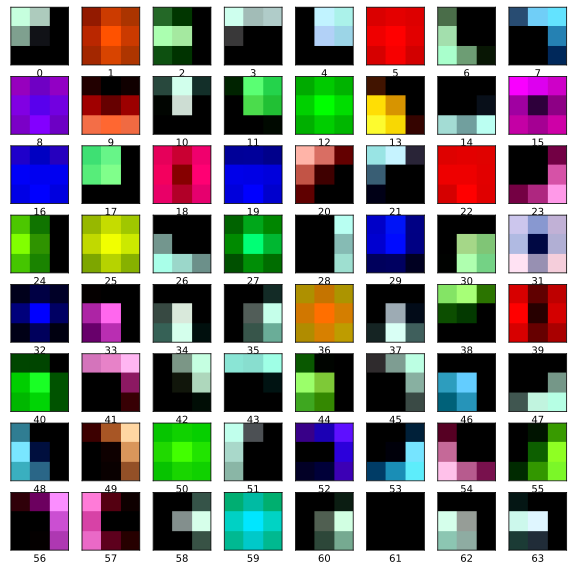

In [88]:
weights = first_layer_weights = vggmodel.get_weights()[0]

plt.figure(figsize=(10, 10))
ax = plt.axes()
num_rows = 8
for i in range(weights.shape[-1]):
    plt.subplot(num_rows, weights.shape[-1] // num_rows, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(kernel_image(weights, i, positive=True), cmap=plt.cm.viridis) #, cmap=plt.cm.binary)
    # plt.colorbar()
    plt.xlabel(str(i))
plt.show()

# Other stuff

## Exercise question

> Do you have an idea what's going on? Why could the classifier "memorize" the training data in the first case, but not in the second case?

Let's reproduce the example first.

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print(f'Accuracy Perceptron dataset n.1: {accuracy_score(Y1, guesses1)}')

classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print(f'Accuracy Perceptron dataset n.2: {accuracy_score(Y2, guesses2)}')

classifier3 = make_pipeline(DictVectorizer(), LinearSVC())
classifier3.fit(X2, Y2)
guesses3 = classifier3.predict(X2)
print(f'Accuracy LinearSVC dataset n.2:  {accuracy_score(Y2, guesses3)}')

Accuracy Perceptron dataset n.1: 1.0
Accuracy Perceptron dataset n.2: 0.5
Accuracy LinearSVC dataset n.2:  0.5


The problem is that the first dataset is **linearly seperable**, whereas the second one is not. Because of that, the linear classifiers aren't able to correctly separate the points in the second dataset.

We can indeed obtain the same accuracy scores by replacing their labels with numerical values. This also allows us to easily visualize the datapoints in the two datasets.

In [ ]:
cities = {
    'Paris': 0,
    'Gothenburg': 1,
    'Sydney': 2,
}
months = {
    'July': 1,
    'December': 0,
}
weather = {
    'rain': 1,
    'sun': 0,
}

X1 = [{'city':cities['Gothenburg'], 'month':months['July']},
      {'city':cities['Gothenburg'], 'month':months['December']},
      {'city':cities['Paris'], 'month':months['July']},
      {'city':cities['Paris'], 'month':months['December']}]
Y1 = [weather['rain'], weather['rain'], weather['sun'], weather['rain']]

X2 = [{'city':cities['Sydney'], 'month':months['July']},
      {'city':cities['Sydney'], 'month':months['December']},
      {'city':cities['Paris'], 'month':months['July']},
      {'city':cities['Paris'], 'month':months['December']}]
Y2 = [weather['rain'], weather['sun'], weather['sun'], weather['rain']]

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print(f'Accuracy Perceptron dataset n.1: {accuracy_score(Y1, guesses1)}')

classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print(f'Accuracy Perceptron dataset n.2: {accuracy_score(Y2, guesses2)}')

classifier3 = make_pipeline(DictVectorizer(), LinearSVC())
classifier3.fit(X2, Y2)
guesses3 = classifier3.predict(X2)
print(f'Accuracy LinearSVC dataset n.2:  {accuracy_score(Y2, guesses3)}')

Accuracy Perceptron dataset n.1: 1.0
Accuracy Perceptron dataset n.2: 0.5
Accuracy LinearSVC dataset n.2:  0.5


As expected, the scores are the same. Let's now see the points on a 2D plane.

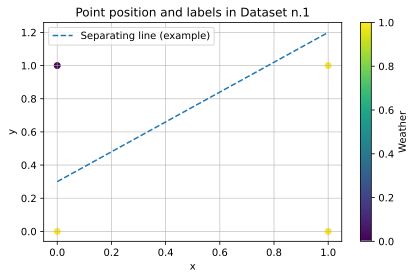

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_coords = []
y_coords = []
for x1 in X1:
    x_coords.append(x1['city'])
    y_coords.append(x1['month'])
plt.scatter(x_coords, y_coords, c=Y1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1) * 0.9 + 0.3, '--', label='Separating line (example)')
plt.grid(which='both', axis='both', alpha=0.7, zorder=1)
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.title('Point position and labels in Dataset n.1')
plt.tight_layout()
plt.colorbar(label='Weather')
plt.show()

For dataset n.1, we can ideally draw a line to separate the points into two separate sets according to their labels. This is however not possible for the points in dataset n.2, as showed as follows.

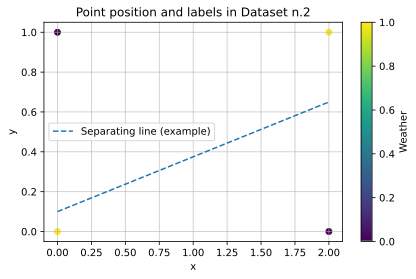

In [ ]:
x_coords = []
y_coords = []
for x2 in X2:
    x_coords.append(x2['city'])
    y_coords.append(x2['month'])
plt.scatter(x_coords, y_coords, c=Y2)
plt.grid(which='both', axis='both', alpha=0.7, zorder=1)
plt.plot(np.linspace(0, 2), np.linspace(0, 1) * 0.55 + 0.1, '--', label='Separating line (example)')
plt.ylabel('y')
plt.xlabel('x')
plt.title('Point position and labels in Dataset n.2')
plt.legend()
plt.tight_layout()
plt.colorbar(label='Weather')
plt.show()

As we can see, there is no straight line which can clearly separate the two sets. Hence, at least one point per label will be missclassified, leading to a lower accuracy score (in our case, 50%).

<!-- The XOR problem: The second dataset is not linearly separable (assign 0s and 1s to the entities and build the truth table). -->

## Introduction: Perceptron

I'll start by importing the provided Perceptron class.

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed
        to be stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        # First compute the output scores
        scores = self.decision_function(X)
        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training
        set. If there are exactly two classes, one of them is associated to
        positive classifier scores, the other one to negative scores. If the
        number of classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])


class Perceptron(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """
    def __init__(self, n_iter=20):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)
        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)
        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        # Perceptron algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):
                # Compute the output score for this instance.
                score = x.dot(self.w)
                # If there was an error, update the weights.
                if y * score <= 0:
                    self.w += y * x

The custom Perceptron class can now be included into a data pipeline and tested.

In [ ]:
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# This function reads the corpus, returns a list of documents, and a list
# of their corresponding polarity labels. 
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y

# Read all the documents.
X, Y = read_data(os.path.join(data_dir, 'all_sentiment_shuffled.txt'))
# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                random_state=0)
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    # NB that this is our Perceptron, not sklearn.linear_model.Perceptron
    Perceptron(n_iter=16)
)
# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'Perceptron training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'Perceptron accuracy: {accuracy:.4f}')
# Save metrics for comparison
models = {
    'Perceptron' : {
        'model': pipeline,
        'training_time': t1-t0,
        'accuracy': accuracy
    },
}

Perceptron training time: 2.61s
Perceptron accuracy: 0.7935


## Implementing the SVC

The SVC `fit()` function shall implement the _hinge loss_ for updating the weight parameter $w$.

In [ ]:
class LinearSVC(LinearClassifier):
    """
    A straightforward implementation of the linear SVC learning algorithm.
    """
    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C

    def fit(self, X, Y):
        """
        Train a linear classifier using the linear SVC learning algorithm.
        """
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)
        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)
        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t = 0
        XY = list(zip(X, Ye))
        for i in range(self.n_iter):
            # NOTE: The shuffling of the trainiing data can be removed, as it
            # causes slowdowns.
            p = np.random.permutation(X.shape[0])
            XY = list(zip(X[p], Ye[p]))
            for x, y in XY:
                t += 1
                eta = 1 / (self.C * t)
                # Compute the output score for this instance.
                score = x.dot(self.w)
                self.w = (1 - eta * self.C) * self.w
                if y * score < 1:
                    self.w += (eta * y) * x

Once that the class is implemented, it can be tested in a data pipeline as in the previous case.

In [ ]:
# Set up the preprocessing steps and the classifier.
svc_pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=5000),
    Normalizer(),
    # NB that this is our LinearSVC, not sklearn.linear_model.LinearSVC
    LinearSVC(n_iter=16, C=1/len(Xtrain))
)
# Train the classifier.
t0 = time.time()
svc_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'SVC training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = svc_pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'SVC accuracy: {accuracy:.4f}')
models['LinearSVC'] = {
    'model': svc_pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

SVC training time: 8.46s
SVC accuracy: 0.8481


## Logistic regression

For implementing a Logistic Regression classifier, the `fit()` function shall include the implementation of a _log loss_. In particular, for each training point, the weight vector $w$ is updated according to the _learning rate_ $\eta$
and the loss gradient:

$\nabla (Loss) = -\frac{y_i}{1 + exp(y_i \cdot w \cdot x_i)} \cdot x_i$

In [ ]:
class LogisticRegression(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)
        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)
        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t = 0
        XY = list(zip(X, Ye))
        for i in range(self.n_iter):
            # NOTE: The shuffling of the trainiing data can be removed, as it
            # causes slowdowns.
            p = np.random.permutation(X.shape[0])
            XY = list(zip(X[p], Ye[p]))
            for x, y in XY:
                t += 1
                eta = 1 / (self.C * t)
                wx = x.dot(self.w)
                self.w = (1 - eta * self.C) * self.w + y / (1 + np.exp(y * wx)) * x

The custom classifier can be included into a pipeline too. The `C`, _i.e._ $λ$ hyperparameter can be tuned to achieve an accuracy score above 80%.

In [ ]:
# Set up the preprocessing steps and the classifier.
lrclassifier_pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    # NB that this is our LogisticRegression, not sklearn.linear_model.LogisticRegression
    LogisticRegression(n_iter=16, C=1/len(Xtrain))
)
# Train the classifier.
t0 = time.time()
lrclassifier_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'Logistic Regression training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = lrclassifier_pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'Logistic Regression accuracy: {accuracy:.4f}')
models['LogisticRegression'] = {
    'model': lrclassifier_pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

Logistic Regression training time: 4.78s
Logistic Regression accuracy: 0.8229


## Comparison

Once all the classifiers have been trained, they can be compared in terms of accuracy and training time.

Perceptron accuracy: 0.794s
LinearSVC accuracy: 0.848s
LogisticRegression accuracy: 0.823s


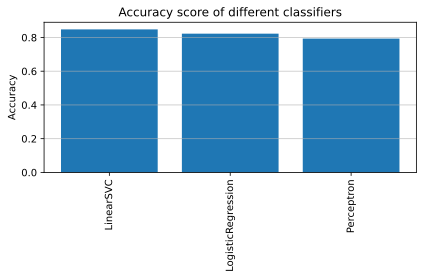

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(model_focus=''):
    scores = []
    models_keys = []
    for model_type in models.keys():
        if model_focus in model_type:
            models_keys.append(model_type)
            print(f'{model_type} accuracy: {models[model_type]["accuracy"]:.3f}s')
            scores.append(models[model_type]['accuracy'])
    # Alphabetically sort scores according to the model types
    scores = [x for _, x in sorted(zip(models_keys, scores))]
    linspace = [x for x in range(len(models_keys))]
    plt.bar(linspace, scores)
    plt.xticks(linspace, [f'{m}' for m in sorted(models_keys)], rotation=90)
    plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
    plt.ylabel('Accuracy')
    plt.title('Accuracy score of different classifiers')
    plt.tight_layout()
    # plt.savefig(os.path.join(data_dir, f'accuracy.pdf'))
    plt.show()

plot_accuracy()

As it can the be seen in the graph above, compared to the Perceptron, both the SVC and Logistic Regression (LR) classifiers perform better in terms of accuracy.

The reason for that might lie in the Perceptron training algorithm, which mearly updates the $w$ vector with the training data $x_i$ numerical values. In contrast, the SVC aims instead at finding the best $w$ which **minimizes** the SVC loss function.

Perceptron training time: 2.605s
LinearSVC training time: 8.464s
LogisticRegression training time: 4.778s


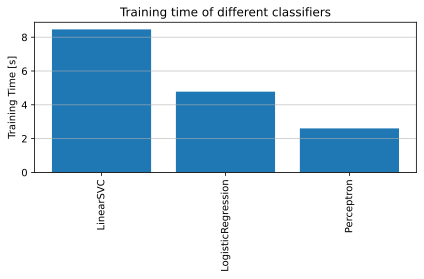

In [ ]:
def plot_training_time(model_focus=''):
    scores = []
    models_keys = []
    for model_type in models.keys():
        if model_focus in model_type:
            models_keys.append(model_type)
            print(f'{model_type} training time: {models[model_type]["training_time"]:.3f}s')
            scores.append(models[model_type]['training_time'])
    # Alphabetically sort scores according to the model types
    scores = [x for _, x in sorted(zip(models_keys, scores))]
    linspace = [x for x in range(len(models_keys))]
    plt.bar(linspace, scores)
    plt.xticks(linspace, [f'{m}' for m in sorted(models_keys)], rotation=90)
    plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
    plt.ylabel('Training Time [s]')
    plt.title('Training time of different classifiers')
    plt.tight_layout()
    # plt.savefig(os.path.join(data_dir, f'accuracy.pdf'))
    plt.show()

plot_training_time()

However, because of its simplicity, the Perceptron classifier is way faster to train, requiring only 2.7s against the 8.5s of the SVC classifier (around $3.25\times$ slower). 

## Bonus task 1: Making the code more efficient

### (a) Faster linear algebra operations

In [ ]:
from scipy.linalg import blas

#### BLAS SVC

In [ ]:
class OptimizedLinearSVC(LinearClassifier):
    """
    A straightforward implementation of the linear SVC learning algorithm.
    """
    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C

    def fit(self, X, Y):
        """
        Train a linear classifier using the linear SVC learning algorithm.
        """
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)
        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)
        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t = 0
        XY = list(zip(X, Ye))
        for i in range(self.n_iter):
            # NOTE: The shuffling of the trainiing data can be removed, as it
            # causes slowdowns.
            p = np.random.permutation(X.shape[0])
            XY = list(zip(X[p], Ye[p]))
            for x, y in XY:
                t += 1
                eta = 1 / (self.C * t)
                # Compute the output score for this instance.
                score = blas.ddot(x, self.w)
                self.w = blas.dscal((1 - eta * self.C), self.w)
                if y * score < 1:
                    blas.daxpy(x, self.w, a=eta * y)

In [ ]:
# Set up the preprocessing steps and the classifier.
svc_pipeline_opt = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=5000),
    Normalizer(),
    OptimizedLinearSVC(n_iter=16, C=1/len(Xtrain))
)
# Train the classifier.
t0 = time.time()
svc_pipeline_opt.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'Optimized SVC training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = svc_pipeline_opt.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'Optimized SVC accuracy: {accuracy:.4f}')
models['OptimizedLinearSVC'] = {
    'model': svc_pipeline_opt,
    'training_time': t1-t0,
    'accuracy': accuracy
}

Optimized SVC training time: 6.32s
Optimized SVC accuracy: 0.8468


Perceptron training time: 2.605s
LinearSVC training time: 8.464s
LogisticRegression training time: 4.778s
OptimizedLinearSVC training time: 6.316s


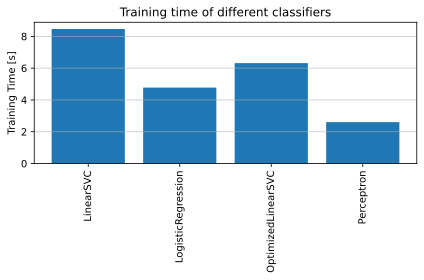

In [ ]:
plot_training_time()

As seen from the comparison above, when using BLAS functions we see a speedup of $1.34\times$ for the SVC classifier. The accuracy score is uneffected.

#### BLAS Logistic Regression

In [ ]:
class OptimizedLogisticRegression(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)
        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)
        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t = 0
        XY = list(zip(X, Ye))
        for i in range(self.n_iter):
            # NOTE: The shuffling of the trainiing data can be removed, as it
            # causes slowdowns.
            p = np.random.permutation(X.shape[0])
            XY = list(zip(X[p], Ye[p]))
            for x, y in XY:
                t += 1
                # NOTE: eta * C = 1 / t
                eta = 1 / (self.C * t)
                self.w = blas.dscal(1 - 1 / t, self.w)
                wx = blas.ddot(x, self.w)
                ywx = blas.dscal(y, wx)
                blas.daxpy(x, self.w, a=y / (1 + np.exp(ywx)))

In [ ]:
# Set up the preprocessing steps and the classifier.
lrclassifier_pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    OptimizedLogisticRegression(n_iter=16, C=1/len(Xtrain))
)
# Train the classifier.
t0 = time.time()
lrclassifier_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'Optimized Logistic Regression training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = lrclassifier_pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'Optimized Logistic Regression accuracy: {accuracy:.4f}')
models['OptimizedLogisticRegression'] = {
    'model': lrclassifier_pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

Optimized Logistic Regression training time: 3.48s
Optimized Logistic Regression accuracy: 0.8347


LogisticRegression training time: 4.778s
OptimizedLogisticRegression training time: 3.483s


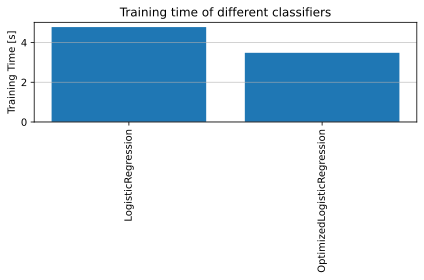

In [ ]:
plot_training_time(model_focus='LogisticRegression')

We see a comparable speedup when optimizing the LR classifier: $1.37\times$. Again, the accuracy score is not changing.

LogisticRegression accuracy: 0.823s
OptimizedLogisticRegression accuracy: 0.835s


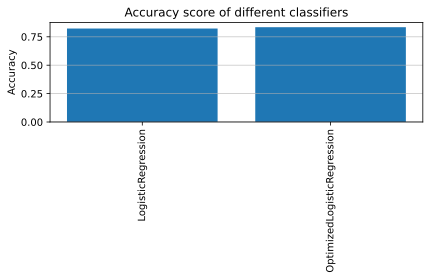

In [ ]:
plot_accuracy(model_focus='LogisticRegression')

### (b) Using sparse vectors

In the following experiments, I've removed the `SelectKBest(k=5000)` element from the pipeline, as it was limiting the total number of features to utilize (and in turn, it determined the maximum length of the input vectors).
 
I decided to limit my analysis to a Vectorizer considering only unigrams. This was based on the fact that training using unigrams only was already comparatively slower than the baseline case and with high accuracy score. Hence, I believe that using both uni- and bi-grams would increase the number of features and lead to similar speedups and slowdown results.

#### Sparse Perceptron

In [ ]:
### Sparse and dense vectors don't collaborate very well in NumPy/SciPy.
### Here are two utility functions that help us carry out some vector
### operations that we'll need.

def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return np.dot(w[x.indices], x.data)


class SparsePerceptron(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """
    def __init__(self, n_iter=20):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)
        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])
        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))
        for i in range(self.n_iter):
            for x, y in XY:
                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = sparse_dense_dot(x, self.w)
                # If there was an error, update the weights.
                if y * score <= 0:
                    # (This corresponds to self.w += y*x above.)
                    add_sparse_to_dense(x, self.w, y)

In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    SparsePerceptron(n_iter=16)
)
# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'PerceptronMaxFeatures training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'PerceptronMaxFeatures accuracy: {accuracy:.4f}')
# Save metrics for comparison
models['PerceptronMaxFeatures'] = {
    'model': pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

PerceptronMaxFeatures training time: 7.16s
PerceptronMaxFeatures accuracy: 0.8279


In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SparsePerceptron(n_iter=16)
)
# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'SparsePerceptron training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'SparsePerceptron accuracy: {accuracy:.4f}')
# Save metrics for comparison
models['SparsePerceptron'] = {
    'model': pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

SparsePerceptron training time: 7.10s
SparsePerceptron accuracy: 0.7935


In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    SparsePerceptron(n_iter=16)
)
# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'SparsePerceptron training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'SparsePerceptron accuracy: {accuracy:.4f}')
# Save metrics for comparison
models['SparsePerceptronMaxFeatures'] = {
    'model': pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

SparsePerceptron training time: 3.89s
SparsePerceptron accuracy: 0.8279


In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    Normalizer(),
    SparsePerceptron(n_iter=16)
)
# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'SparsePerceptron training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'SparsePerceptron accuracy: {accuracy:.4f}')
# Save metrics for comparison
models['SparsePerceptronMaxFeaturesBigrams'] = {
    'model': pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

SparsePerceptron training time: 8.83s
SparsePerceptron accuracy: 0.8636


Perceptron training time: 2.605s
PerceptronMaxFeatures training time: 7.162s
SparsePerceptron training time: 7.098s
SparsePerceptronMaxFeatures training time: 3.885s
SparsePerceptronMaxFeaturesBigrams training time: 8.832s


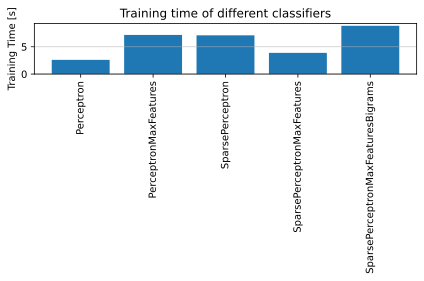

In [ ]:
plot_training_time(model_focus='Perceptron')

#### Sparse SVC

In [ ]:
class SparseLinearSVC(LinearClassifier):
    """
    A straightforward implementation of the linear SVC learning algorithm.
    """
    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C

    def fit(self, X, Y):
        """
        Train a linear classifier using the linear SVC learning algorithm.
        """
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)
        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)
        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t = 0
        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))
        for i in range(self.n_iter):
            # NOTE: The shuffling of the trainiing data was removed, as it
            # caused too much slowdown.
            # p = np.random.permutation(X.shape[0])
            # XY = list(zip(X[p], Ye[p]))
            for x, y in XY:
                t += 1
                eta = 1 / (self.C * t)
                # Compute the output score for this instance.
                score = sparse_dense_dot(x, self.w)
                self.w = (1 - eta * self.C) * self.w
                if y * score < 1:
                    add_sparse_to_dense(x, self.w, y * eta)

In [ ]:
# Set up the preprocessing steps and the classifier.
svc_pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    LinearSVC(n_iter=16, C=1/len(Xtrain))
)
# Train the classifier.
t0 = time.time()
svc_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'SVCMaxFeatures training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = svc_pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'SVCMaxFeatures accuracy: {accuracy:.4f}')
models['LinearSVCMaxFeatures'] = {
    'model': svc_pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

SVCMaxFeatures training time: 67.13s
SVCMaxFeatures accuracy: 0.8414


In [ ]:
# Set up the preprocessing steps and the classifier.
svc_pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    SparseLinearSVC(n_iter=16, C=1/len(Xtrain))
)
# Train the classifier.
t0 = time.time()
svc_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'SVC training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = svc_pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'SVC accuracy: {accuracy:.4f}')
models['SparseLinearSVCMaxFeatures'] = {
    'model': svc_pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

SVC training time: 16.71s
SVC accuracy: 0.8414


LinearSVC training time: 8.464s
OptimizedLinearSVC training time: 6.316s
LinearSVCMaxFeatures training time: 67.126s
SparseLinearSVCMaxFeatures training time: 16.713s


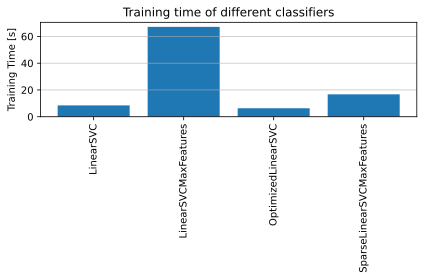

In [ ]:
plot_training_time(model_focus='SVC')

We can see that when considering all available features (marked as "MaxFeatures"), the training time of the unoptimized SVC classifier is more than $8\times$ slower than the original case. On the other hand, the slowdown is only of $2\times$ when sparse operations are utilized instead.

#### Sparse Logistic Regression

In [ ]:
class SparseLogisticRegression(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)
        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)
        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t = 0
        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))
        for i in range(self.n_iter):
            # NOTE: The shuffling of the trainiing data was removed, as it
            # caused too much slowdown.
            # p = np.random.permutation(X.shape[0])
            # XY = list(zip(X[p], Ye[p]))
            for x, y in XY:
                t += 1
                # NOTE: eta * C = 1 / t
                self.w = (1 - 1 / t) * self.w
                ywx = y * sparse_dense_dot(x, self.w)
                add_sparse_to_dense(x, self.w, y / (1 + np.exp(ywx)))

In [ ]:
# Set up the preprocessing steps and the classifier.
lrclassifier_pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    LogisticRegression(n_iter=16, C=1/len(Xtrain))
)
# Train the classifier.
t0 = time.time()
lrclassifier_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'LogisticRegressionMaxFeatures training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = lrclassifier_pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'LogisticRegressionMaxFeatures accuracy: {accuracy:.4f}')
models['LogisticRegressionMaxFeatures'] = {
    'model': lrclassifier_pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

LogisticRegressionMaxFeatures training time: 64.79s
LogisticRegressionMaxFeatures accuracy: 0.8414


In [ ]:
# Set up the preprocessing steps and the classifier.
lrclassifier_pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    SparseLogisticRegression(n_iter=16, C=1/len(Xtrain))
)
# Train the classifier.
t0 = time.time()
lrclassifier_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'SparseLogisticRegressionMaxFeatures training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = lrclassifier_pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'SparseLogisticRegressionMaxFeatures accuracy: {accuracy:.4f}')
models['SparseLogisticRegressionMaxFeatures'] = {
    'model': lrclassifier_pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

SparseLogisticRegressionMaxFeatures training time: 22.04s
SparseLogisticRegressionMaxFeatures accuracy: 0.8422


LogisticRegression training time: 4.778s
OptimizedLogisticRegression training time: 3.483s
LogisticRegressionMaxFeatures training time: 64.785s
SparseLogisticRegressionMaxFeatures training time: 22.038s


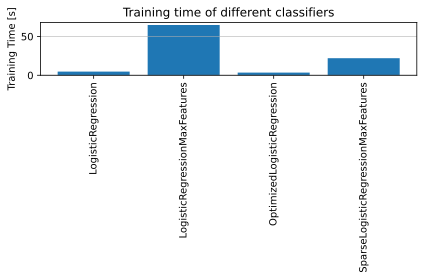

In [ ]:
plot_training_time(model_focus='LogisticRegression')

A similar comparison analysis can be made for the LR classifier. Without optimization, the training time is $13.6\times$ longer than without using all available features. The training time of utilizing all features and sparse operations is instead of $4.6\times$.

#### Summary

PerceptronMaxFeatures training time: 7.162s
SparsePerceptronMaxFeatures training time: 3.885s
SparsePerceptronMaxFeaturesBigrams training time: 8.832s
LinearSVCMaxFeatures training time: 67.126s
SparseLinearSVCMaxFeatures training time: 16.713s
LogisticRegressionMaxFeatures training time: 64.785s
SparseLogisticRegressionMaxFeatures training time: 22.038s


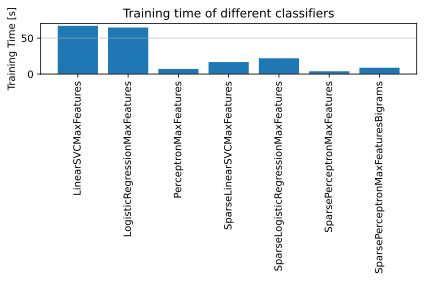

In [ ]:
plot_training_time(model_focus='MaxFeatures')

### (c) Speeding up the scaling operation

#### Opt. Scaling Logistic SVC

In [ ]:
class OptScalingSparseLinearSVC(LinearClassifier):
    """
    A straightforward implementation of the linear SVC learning algorithm.
    """
    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C

    def fit(self, X, Y):
        """
        Train a linear classifier using the linear SVC learning algorithm.
        """
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)
        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)
        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        # NOTE: To avoid dividing by zero, we start from iteration t = 1
        t = 1
        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))
        w_scaler = 1
        for i in range(self.n_iter):
            # NOTE: The shuffling of the trainiing data was removed, as it
            # caused too much slowdown.
            # p = np.random.permutation(X.shape[0])
            # XY = list(zip(X[p], Ye[p]))
            for x, y in XY:
                t += 1
                eta = 1 / (self.C * t)
                w_scaler = (1 - eta * self.C) * w_scaler
                score = w_scaler * sparse_dense_dot(x, self.w)
                if y * score < 1:
                    add_sparse_to_dense(x, self.w, eta * y / w_scaler)
        self.w = w_scaler * self.w

In [ ]:
# Set up the preprocessing steps and the classifier.
svc_pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    OptScalingSparseLinearSVC(n_iter=16, C=1/len(Xtrain))
)
# Train the classifier.
t0 = time.time()
svc_pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print(f'OptScalingSparseLinearSVCMaxFeatures training time: {t1 - t0:.2f}s')
# Evaluate on the test set.
Yguess = svc_pipeline.predict(Xtest)
accuracy = accuracy_score(Ytest, Yguess)
print(f'OptScalingSparseLinearSVCMaxFeatures accuracy: {accuracy:.4f}')
models['OptScalingSparseLinearSVCMaxFeatures'] = {
    'model': svc_pipeline,
    'training_time': t1-t0,
    'accuracy': accuracy
}

OptScalingSparseLinearSVCMaxFeatures training time: 4.97s
OptScalingSparseLinearSVCMaxFeatures accuracy: 0.8401


LinearSVCMaxFeatures training time: 67.126s
SparseLinearSVCMaxFeatures training time: 16.713s
OptScalingSparseLinearSVCMaxFeatures training time: 4.973s


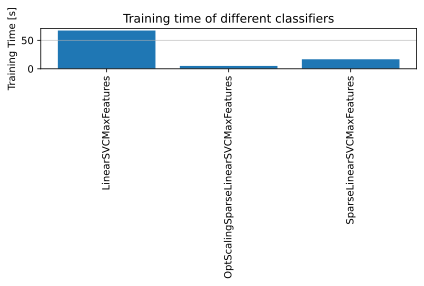

In [ ]:
plot_training_time(model_focus='SVCMaxFeatures')

As mentioned above, the training time of the unoptimized SVC classifier is more than $8\times$ slower than the original case. The slowdown is only of $2\times$ when sparse operations are utilized instead. Finally, when also reducing the scaling operations, _i.e._ applying the scaling "trick", the slowdown is of $0.59\times$. This means that by utilizing the combination of sparse operations and scaling trick, the training is actually $1.7\times$ **faster** when using all available features than when using only a limited set of them (baseline case).

#### Opt. Scaling Logistic Regression

(TODO).

# Converting Notebook to PDF

The following two cells can be ignored for grading, as they just convert this notebook into a PDF file.

In [ ]:
%%capture
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic
!apt-get install -y inkscape
!add-apt-repository -y universe
!add-apt-repository -y ppa:inkscape.dev/stable
!apt-get update -y
!apt install -y inkscape

In [ ]:
%%capture
import re

ASSIGNMENT_NAME = 'DAT340 - Assignment ' + ASSIGNMENT_ID.split('_')[1]
pdf_dir = os.path.join(os.path.abspath(''), 'drive', 'MyDrive')
pdf_dir = os.path.join(pdf_dir, 'Colab Notebooks', 'dat340', ASSIGNMENT_ID)
pdf_filename = re.escape(os.path.join(pdf_dir, ASSIGNMENT_NAME)) + '.ipynb'

!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=False $pdf_filename